# Supplementary notebook

In [1]:
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time
import sys
import pandas as pd
import numpy as np
from mlxtend.evaluate import permutation_test
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, RidgeClassifier,Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, LeaveOneOut, train_test_split, cross_val_score, cross_validate,cross_val_predict, StratifiedKFold, KFold, GroupKFold, LeavePGroupsOut, ShuffleSplit
from sklearn.decomposition import PCA
from sklearn import preprocessing 
from sklearn.feature_selection import SelectKBest, f_regression
import warnings
import pickle
from tqdm import tqdm
from glob import glob
from sklearn.feature_selection import VarianceThreshold
import networkx as nx
from joblib import Parallel, delayed
import argparse
import os, subprocess
warnings.filterwarnings("ignore")
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA
from scipy.spatial import distance
import shutil
import pandas as pd
import seaborn as sns

In [42]:
16/32

0.5

In [43]:
3/(58-32)

0.11538461538461539

In [32]:
(58 - len(emotion))

36

In [2]:
# phenotypes
rootDir = '/Users/rk/Desktop/projects/replicability/in/'

alertness = ['MMSE_Score','PSQI_Score']
cognition = ['PicSeq_AgeAdj','CardSort_AgeAdj','Flanker_AgeAdj','PMAT24_A_CR','CogFluidComp_AgeAdj','CogCrystalComp_AgeAdj',
'CogEarlyComp_AgeAdj','CogTotalComp_AgeAdj','ReadEng_AgeAdj','PicVocab_AgeAdj','ProcSpeed_AgeAdj','DDisc_AUC_200','VSPLOT_TC','SCPT_SEN','SCPT_SPEC']
memory = ['IWRD_TOT','ListSort_AgeAdj']
emotion = ['ER40ANG','ER40FEAR','ER40HAP','ER40NOE','ER40SAD','AngAffect_Unadj','AngHostil_Unadj','AngAggr_Unadj','FearAffect_Unadj',
'FearSomat_Unadj','Sadness_Unadj','LifeSatisf_Unadj','MeanPurp_Unadj','PosAffect_Unadj','Friendship_Unadj','Loneliness_Unadj',
'PercHostil_Unadj','PercReject_Unadj','EmotSupp_Unadj','InstruSupp_Unadj','PercStress_Unadj','SelfEff_Unadj']
motor = ['Endurance_AgeAdj', 'GaitSpeed_Comp', 'Dexterity_AgeAdj', 'Strength_AgeAdj']
personality = ['NEOFAC_A','NEOFAC_O','NEOFAC_C','NEOFAC_N','NEOFAC_E']
sensory = ['Noise_Comp','Odor_AgeAdj','PainIntens_RawScore','PainInterf_Tscore','Taste_AgeAdj','Mars_Final']
phenotype_names = alertness + cognition + memory + emotion + motor + personality + sensory + ['age_num' ,'Gender']
groups = np.array([1, 1, 2,2,2,2,2,2,2,2,2,2,2,2,2,2,2, 3,3, 4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4, 5,5,5,5, 6,6,6,6,6, 7,7,7,7,7,7, 8,8])
battery = ['alertness', 'cognition', 'memory', 'emotion', 'motor', 'personality', 'sensory', 'demography']
sample_size = np.arange(25, 450, 25)

In [3]:
def main_func(num, window_size, thresh):
  conntype=num
  replicability_all_phenotypes = []
  for phen in phenotype_names:
      with open(f'{rootDir}/replicability_{phen}_conntype_{conntype}.pickle', 'rb') as file:
          data = pickle.load(file)
          data = np.convolve(data, np.ones(window_size)/window_size, mode='same')
          replicability_all_phenotypes.append(data)
  
  replicability_conn = pd.DataFrame(replicability_all_phenotypes)
  replicability_conn.index = phenotype_names

  val_all = np.zeros((replicability_conn.shape[0], 1))
  sample_all = np.zeros((replicability_conn.shape[0]))
  for i in range(replicability_conn.shape[0]):
    temp = replicability_conn.iloc[i].max()
    if temp > thresh:
      val_all[i] = np.argmax(np.array(replicability_conn.iloc[i])>thresh)
      sample_all[i] = int(sample_size[int(val_all[i])])
    else:
       val_all[i] = np.nan
       sample_all[i] = np.nan
       
  return replicability_conn, (np.count_nonzero(~np.isnan(val_all))/replicability_conn.shape[0] )*100, sample_all


In [4]:
replicability_0, percent_replicability_0, samples_needed_0 = main_func(0, 4, 0.8)
replicability_1, percent_replicability_1, samples_needed_1 = main_func(1, 4, 0.8)
replicability_2, percent_replicability_2, samples_needed_2 = main_func(2, 4, 0.8)
replicability_3, percent_replicability_3, samples_needed_3 = main_func(3, 4, 0.8)
replicability_4, percent_replicability_4, samples_needed_4 = main_func(4, 4, 0.8)

print([percent_replicability_0, percent_replicability_1, percent_replicability_2, percent_replicability_3, percent_replicability_4])


[31.03448275862069, 24.137931034482758, 29.310344827586203, 25.862068965517242, 27.586206896551722]


In [5]:
results_sample_size = pd.DataFrame([samples_needed_0, samples_needed_1, samples_needed_2, samples_needed_3, samples_needed_4]).T
results_sample_size.index = phenotype_names
results_sample_size.columns = ['Streamlines', 'FA', 'RD', 'AD', 'ADC']
results_sample_size.dropna(how='all', inplace=True)

In [6]:
group_labels = []
battery_labels = [] 
for i in results_sample_size.index:
    group_labels.append(groups[phenotype_names.index(i)])
    battery_labels.append(battery[groups[phenotype_names.index(i)]-1])
results_sample_size['groups']=group_labels
results_sample_size['battery'] = battery_labels
results_sample_size.head()

,Streamlines,FA,RD,AD,ADC,groups,battery
CardSort_AgeAdj,400.0,NaN,NaN,NaN,NaN,2,cognition
Flanker_AgeAdj,325.0,NaN,375.0,NaN,NaN,2,cognition
PMAT24_A_CR,150.0,300.0,325.0,325.0,300.0,2,cognition
CogFluidComp_AgeAdj,300.0,NaN,375.0,400.0,400.0,2,cognition
CogCrystalComp_AgeAdj,125.0,275.0,250.0,275.0,275.0,2,cognition


In [7]:
replicability_1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
MMSE_Score,0.000000,0.000000,0.000000,0.000000,0.125000,0.125000,0.187500,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN
PSQI_Score,0.000000,0.000000,0.050000,0.050000,0.050000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PicSeq_AgeAdj,0.000000,0.062500,0.062500,0.130682,0.130682,0.068182,0.139610,0.133929,0.133929,0.175595,0.166667,0.104167,0.181090,0.139423,0.076923,0.076923,0.000000
CardSort_AgeAdj,0.083333,0.083333,0.083333,0.083333,0.000000,NaN,NaN,NaN,NaN,0.083333,0.027778,0.043403,0.098958,0.161458,0.133681,0.143056,0.087500
Flanker_AgeAdj,0.055556,0.149306,0.177083,0.227083,0.239710,0.229293,0.284848,0.293672,0.371324,0.407038,0.465596,0.555421,0.541167,0.609619,0.652728,0.710975,0.579397


In [28]:
results_sample_size.fillna(0, inplace=True)
results_sample_size


,Streamlines,FA,RD,AD,ADC,groups,battery
CardSort_AgeAdj,400.0,0.0,0.0,0.0,0.0,2,cognition
Flanker_AgeAdj,325.0,0.0,375.0,0.0,0.0,2,cognition
PMAT24_A_CR,150.0,300.0,325.0,325.0,300.0,2,cognition
CogFluidComp_AgeAdj,300.0,0.0,375.0,400.0,400.0,2,cognition
CogCrystalComp_AgeAdj,125.0,275.0,250.0,275.0,275.0,2,cognition
CogEarlyComp_AgeAdj,175.0,325.0,275.0,325.0,300.0,2,cognition
CogTotalComp_AgeAdj,150.0,225.0,225.0,225.0,225.0,2,cognition
ReadEng_AgeAdj,150.0,300.0,275.0,325.0,300.0,2,cognition
PicVocab_AgeAdj,125.0,275.0,250.0,275.0,275.0,2,cognition
VSPLOT_TC,125.0,275.0,250.0,275.0,275.0,2,cognition


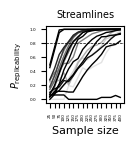

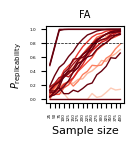

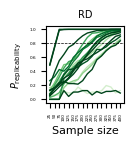

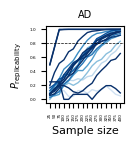

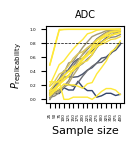

In [10]:
list = ['Streamlines', 'FA', 'RD', 'AD', 'ADC']
replicabilities = [replicability_0, replicability_1, replicability_2, replicability_3, replicability_4]

colormaps = ['Greys', 'Reds', 'Greens', 'Blues', 'cividis']
for enu, df in enumerate(replicabilities):
    colormap = plt.get_cmap(colormaps[enu % len(colormaps)])
    c = 0.2
    line_width = 1
    fig, ax = plt.subplots(figsize=(1,1))
    for i in results_sample_size[list[enu]].index:
        df = df.fillna(0)
        plt.plot(df.loc[i][:-1], linewidth = line_width, color = colormap(c))
        c=c+0.075
    ax.set_title(list[enu], fontsize = 7)
    ax.set_xticks(range(len(sample_size)-1))
    ax.set_xticklabels(sample_size[:-1], rotation=90, fontsize=3)  
    ax.set_yticks(np.arange(0, 1.2, .2))
    ax.set_yticklabels(np.around(np.arange(0, 1.2, .2), decimals=1), fontsize=3)
    ax.set_ylabel('$P_{\mathrm{replicability}}$', fontsize=7)
    ax.set_xlabel('Sample size', fontsize=8)
    ax.axhline(y=0.8, color='black', linestyle='--', linewidth=0.5)
    #plt.savefig(f'./images/line_{list[enu]}.svg', dpi=1200, bbox_inches='tight')
    #plt.savefig(f'../fig/line_{list[enu]}.jpeg', dpi=1200, bbox_inches='tight')



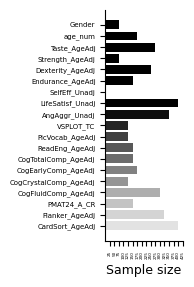

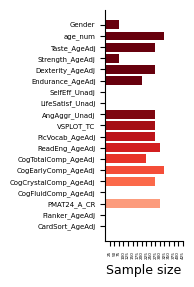

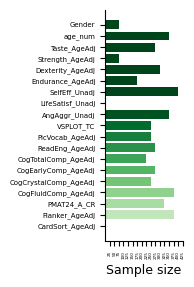

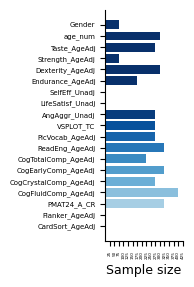

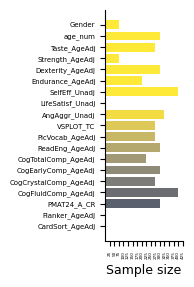

In [11]:
colormaps = ['Greys', 'Reds', 'Greens', 'Blues', 'cividis']
for idx, modality in enumerate(list):
    colormap = plt.get_cmap(colormaps[idx % len(colormaps)])
    #colormap = plt.cm.Pink
    c = 0.2
    fig, ax = plt.subplots(figsize=(1,3))
    for enu, i in enumerate(results_sample_size[modality]):
        ax.barh(enu, int(i), color=colormap(c))
        c=c+0.075
    ax.set_yticks(range(len(results_sample_size.index)))
    ax.set_yticklabels(results_sample_size[modality].index, fontsize=5)
    ax.set_xticks(sample_size)
    ax.set_xticklabels(sample_size, rotation=90, fontsize=3)  
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Sample size', fontsize=9)
    #plt.savefig(f'./images/bar_{modality}_bar.svg', dpi=1200, bbox_inches='tight')
    #plt.savefig(f'../fig/bar_{modality}_bar.jpeg', dpi=1200, bbox_inches='tight')

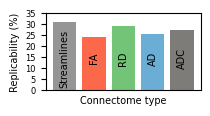

In [12]:
# Assuming replicability_vals are defined
replicability_vals = [percent_replicability_0, percent_replicability_1, percent_replicability_2, percent_replicability_3, percent_replicability_4]

fig, ax = plt.subplots(figsize=(2, 1))

colormaps = ['Greys', 'Reds', 'Greens', 'Blues', 'cividis']

for enu, (i, cmap_name) in enumerate(zip(replicability_vals, colormaps)):
    colormap = plt.get_cmap(cmap_name)
    ax.bar(enu, i, color=colormap(0.5))  # Using a mid-point value for the color

ax.set_xticks(range(len(replicability_vals)))
ax.set_xticks([])

ax.set_ylabel('Replicability (%)', fontsize=7)
ax.set_xlabel('Connectome type', fontsize=7)

ax.set_yticks(range(0, 40, 5))
ax.set_yticklabels(range(0, 40, 5), fontsize=6)

labels = ['Streamlines', 'FA', 'RD', 'AD', 'ADC']
for enu, label in enumerate(labels):
    ax.text(enu, 14.5, label, ha='center', va='center', rotation=90, fontsize=7)

#plt.savefig('./images/main_replicability_bar.svg', dpi=1200, bbox_inches='tight')
#plt.savefig('../fig/main_replicability_bar.png', dpi=1200, bbox_inches='tight')
plt.show()


In [13]:
from scipy.stats import pearsonr
mean_r2_all = []
sample_all = []
for i, phen in enumerate(results_sample_size.index):
    for j, model in enumerate(list):
        with open(f'{rootDir}/y_hat_rep_{phen}_conntype_{j}.pickle', 'rb') as file:
            y_hat_rep = pickle.load(file)
            try:
                index = np.where(sample_size==int(results_sample_size.iloc[i,j]))[0][0] 
                var1 = y_hat_rep[index]
            except IndexError:
                pass
        with open(f'{rootDir}/y_true_rep_{phen}_conntype_{j}.pickle', 'rb') as file:
            y_true_rep = pickle.load(file)
            try:
                index = np.where(sample_size==int(results_sample_size.iloc[i,j]))[0][0] 
                var2 = y_true_rep[index]
            except IndexError:
                pass
        r2_all = np.zeros(100)
        for k in range(100):
            correlation = []
            correlation, _ = pearsonr(var1[:,k], var2[:,k])
            r2_all[k] = correlation*correlation
        mean_r2 = r2_all.mean()
        mean_r2_all.append(mean_r2)    
        sample_all.append(results_sample_size.iloc[i,j])

In [14]:
# Reshape data into (19, 5)
r2 = np.array(mean_r2_all).reshape((19, 5))
s = np.array(sample_all).reshape((19, 5))

# Concatenate r2 and s along the columns
empirical = pd.DataFrame(np.concatenate((r2, s), axis=1))

# Set index
empirical.index = pd.Index(range(19))

# Reshape the DataFrame
reshaped_r2 = empirical.iloc[:, :5].values.flatten()
reshaped_s = empirical.iloc[:, 5:].values.flatten()
reshaped_data = np.column_stack((reshaped_r2, reshaped_s))

reshaped_df = pd.DataFrame(reshaped_data, columns=['R2', 'n'])

# Remove rows where either 'R2' or 'n' is zero
reshaped_df = reshaped_df[~((reshaped_df['R2'] == 0) | (reshaped_df['n'] == 0))]

import numpy as np
from scipy.stats import t
import matplotlib.pyplot as plt

# Functions
def r2t(r, n):
    return (r * np.sqrt(n - 2)) / np.sqrt(1 - r ** 2)

def p_rep(t_stat, df):
    return t.cdf(np.abs(t_stat) / np.sqrt(2), df)

def ps_rep(t_stat, df, alpha):
    term1 = np.abs(t_stat) / np.sqrt(2)
    #term2 = t.ppf(1 - alpha / 2, df) / np.sqrt(2)
    term2 = t.ppf(1 - alpha, df) / np.sqrt(2) # one tailed
    return t.cdf(term1 - term2, df)

def r2psrep(r, n):
    return ps_rep(r2t(r, n), n - 2, 0.05)

# Initial values
n = 1000
theory_res=[]
for i in tqdm(reshaped_df.iloc[:,0]):
    r2 = i
    # Calculate t_obs and ps_rep for initial values
    tobs = r2t(np.sqrt(r2), n)
    ps_rep_val = ps_rep(tobs, n - 2, 0.05)

    # Calculate ps_rep values for different sample sizes
    psrep_vals = [r2psrep(np.sqrt(r2), i) for i in range(1, 1001)]

    # Minimum sample size for 80% power
    n_vals = np.where(np.array(psrep_vals) > 0.8)[0]
    n_min_80_power = n_vals[0] + 1 if n_vals.size > 0 else np.nan
    theory_res.append([np.log10(i), n_min_80_power, i])
theory_res = np.array(theory_res)

100%|██████████| 80/80 [00:05<00:00, 13.71it/s]


In [41]:
1/58

0.017241379310344827

Text(0, 0.5, 'Sample size')

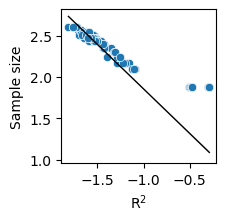

In [15]:
fig, ax = plt.subplots(figsize=(2,2))

sns.scatterplot(x=np.log10(reshaped_df['R2']), y=np.log10(reshaped_df['n']))
sns.regplot(x=theory_res[:,0], y=np.log10(theory_res[:,1]), color='black', scatter_kws={"alpha":0.0},  line_kws={"linewidth": 1})
ax.set_xlabel(r'$\mathrm{R}^2$', fontsize=10)
ax.set_ylabel('Sample size', fontsize=10)

#plt.savefig(f'./images/bar_kileens_plot.svg', dpi=1200, bbox_inches='tight')

In [16]:
print(10 ** -1.5 *100)
print(10 ** -1 * 100)
print(10 ** -.5 * 100)

print(10 ** 1)
print(10 ** 1.5)
print(10 ** 2)
print(10 ** 2.5)

3.162277660168379
10.0
31.622776601683793
10
31.622776601683793
100
316.22776601683796


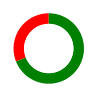

In [26]:
import matplotlib.pyplot as plt

# Data to plot
labels = '', ''
sizes = [31, 69]
colors = ['red', 'green']

# Create a doughnut plot
fig, ax = plt.subplots(figsize=(1,1))
ax.pie(sizes, labels=labels, colors=colors, startangle=90, wedgeprops=dict(width=0.3))

# Draw center circle for doughnut shape
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')  
plt.savefig(f'./replicability_myst/images/pieplot_1.svg', dpi=1200, bbox_inches='tight')

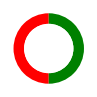

In [45]:

# Data to plot
labels = '', ''
sizes = [50, 50]
colors = ['red', 'green']

# Create a doughnut plot
fig, ax = plt.subplots(figsize=(1,1))
ax.pie(sizes, labels=labels, colors=colors, startangle=90, wedgeprops=dict(width=0.3))

# Draw center circle for doughnut shape
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')  
plt.savefig(f'./replicability_myst/images/pieplot_2.svg', dpi=1200, bbox_inches='tight')

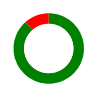

In [44]:

# Data to plot
labels = '', ''
sizes = [11.5, 100-11.5]
colors = ['red', 'green']

# Create a doughnut plot
fig, ax = plt.subplots(figsize=(1,1))
ax.pie(sizes, labels=labels, colors=colors, startangle=90, wedgeprops=dict(width=0.3))

# Draw center circle for doughnut shape
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')  
plt.savefig(f'./replicability_myst/images/pieplot_3.svg', dpi=1200, bbox_inches='tight')